In [32]:
class pool:
    def __init__(self,rD ,sF):
        self.rD = rD
        self.sF = sF
        self.rF = sF
        self.sD = rD
        self.limitrF = sF
        
    def getNetPrice(self):
        return self.sD/self.sF
    
    def getMarketPrice(self):
        return self.rD/self.rF
    
    def getPrice(self, buy=True):
        if buy:
            return max(self.getNetPrice(), self.getMarketPrice())
        else:
            return min(self.getNetPrice(), self.getMarketPrice())
    
    def fillLiquidity(self):
        net = self.getNetPrice()
        rD = self.limitrF*net
        if rD < self.sD:
            self.rF = self.limitrF
            self.rD = rD
        else:
            self.rF = self.sD/net
            self.rD = self.sD
        
    def buyF(self, n):
        if self.rF > n > 0:
            net_p = self.getNetPrice()
            market_p = self.getMarketPrice()
            self.sF += (n*0.9985) # 0.15% fee
            if market_p >= net_p:
                K = self.rD*self.rF
                self.rF -= n
                rD = K/self.rF
                # exchange by K AMM
                incomeD = rD - self.rD
                # supply change
                self.sD += incomeD
                self.rD = rD
            else:
                self.rF -= n
                # exchange by net price
                incomeD = n*net_p
                self.sD += incomeD
                # [1]repair by reduce rD
                self.rD += incomeD
            return True
        else:
            return False
    
    def sellF(self, n):
        # assert self.sF > n # 可能市面上都没有足够的F了 
        # 如果该池铸出的流动性全部收回了，此处应当如何处理？
        if self.sF > n >0:
            net_p = self.getNetPrice()
            market_p = self.getMarketPrice()
            self.sF -= n
            if net_p >= market_p:
                K = self.rD*self.rF
                self.rF += n
                # exchange by market price
                rD = K/self.rF
                outD = self.rD - rD
                self.rD = rD
            else:
                self.rF += n
                # exchange by net price
                outD = n*net_p
                self.rD -= outD
            # supply change
            self.sD -= (outD*0.9985) # 0.15% fee           
            return True
        else:
            return False

In [33]:
p1 = pool(1000,1000)
p1.buyF(100)
print(p1.getMarketPrice())
print(p1.getNetPrice())

p2 = pool(1000,1000)
for i in range(100):
    p2.buyF(1)
print(p2.getMarketPrice())
print(p2.getNetPrice())

1.2345679012345678
1.0102387699332738
1.2345679012345672
1.0102387699332778


In [34]:
p1 = pool(1000,1000)
p1.sellF(100)
print(p1.getMarketPrice())
print(p1.getNetPrice())

p2 = pool(1000,1000)
for i in range(100):
    p2.sellF(1)
print(p2.getMarketPrice())
print(p2.getNetPrice())

0.8264462809917356
1.0102525252525252
0.8264462809917354
1.0102525252525256


In [48]:
p1 = pool(1000,1000)
p1.sellF(100)
p1.buyF(100)
print(p1.getMarketPrice())
print(p1.getNetPrice())

p2 = pool(1000,1000)
for i in range(1000):
    assert p2.sellF(1)
    assert p2.buyF(1)
print(p2.getMarketPrice())
print(p2.getNetPrice())

1.0101161616161616
1.010404085865405
1.0025047581417517
1.0055130276885844


In [59]:
p1 = pool(1000,1000)
p1.buyF(100)
p1.sellF(99.85)
print(p1.getMarketPrice())
print(p1.getNetPrice())

p2 = pool(1000,1000)
for i in range(1000):
    assert p2.buyF(1)
    assert p2.sellF(0.9985)
print(p2.getMarketPrice())
print(p2.getNetPrice())

1.0103903284825462
1.0103900784450406
1.0040124012828595
1.004007131430384


In [60]:
p2.fillLiquidity()
p2.getNetPrice()

1.004007131430384

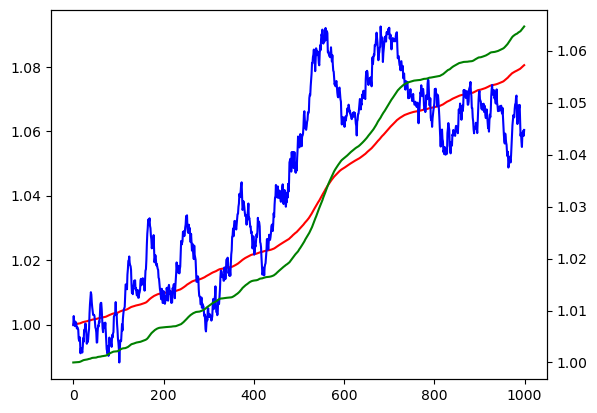

In [63]:
import matplotlib.pyplot as plt
import random

# draw the net asset curve
def draw_net_asset_curve(p, n):
    net_price = []
    market_price = []
    k_list = []
    k_begin = p.rD*p.rF
    step = n//1000
    for i in range(n):
        # random trade
        dirction = random.randint(0,1)
        if dirction > 0:
            p.buyF(1)
        else:
            p.sellF(0.9985)
        k_new = p.rD*p.rF/k_begin
        if k_new < 0.8:
            p.fillLiquidity()
        if i % step == 0:
            net_price.append(p.getNetPrice())
            market_price.append(p.getMarketPrice())
            k_list.append(k_new)
    plt.plot(net_price, color='red')
    plt.plot(market_price, color='blue')
    plt.twinx()
    plt.plot(k_list, color='green')
    plt.show()

p = pool(10000,10000)
nets = draw_net_asset_curve(p, 100000)

In [64]:
print(p.rD, p.rF, p.sD, p.sF)

10638.101695571246 10008.936999984708 10715.594311013354 9916.126000000026


In [98]:
index = 920
nets[index:index+10]

[1.0202822039437895,
 1.021531860633045,
 1.0224711139068883,
 1.024669436223167,
 1.0262454627954292,
 1.0282487364503792,
 1.0299417798347401,
 1.0315340793376984,
 1.032918060082778,
 1.0344126600828962]

In [139]:
(5000000 * 0.0015)/10_000

0.75

ts begin 30000


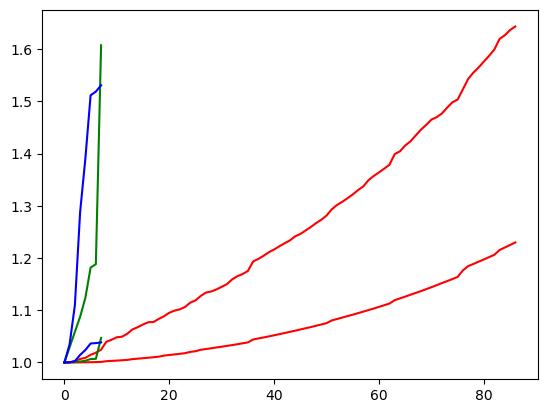

35905.05100002719

In [82]:
import numpy as np
# n个10000稳定币的池子
num_pools = 3
num_tokens = 10000
pools = [pool(num_tokens,num_tokens) for i in range(num_pools)]
ts = num_tokens*num_pools
print('ts begin', ts)

net_prices = [[pools[i].getNetPrice()] for i in range(num_pools)]
market_prices = [[pools[i].getMarketPrice()] for i in range(num_pools)]
# k_list = [[] for i in range(num_pools)]
k_begin = num_tokens**2
step = ts//100

trasctions = 1*ts
for i in range(trasctions):
    # random trade
    # poolid = random.randint(0,num_pools-1)
    direction = random.randint(0,9)
    poolid = 0
    if direction > 3:
        poolnets = [p.getPrice(buy=True) for p in pools]
        poolid = poolnets.index(min(poolnets))
        if pools[poolid].buyF(1):
            ts += 0.9985
    else:
        poolnets = [p.getPrice(buy=False) for p in pools]
        poolid = poolnets.index(max(poolnets))
        if pools[poolid].sellF(1):
            ts -= 1
    k_new = pools[poolid].rD*pools[poolid].rF/k_begin
    if k_new < 0.8:
        pools[poolid].fillLiquidity()
    if i % step == 0:
        net_prices[poolid].append(pools[poolid].getNetPrice())
        market_prices[poolid].append(pools[poolid].getMarketPrice())
        # k_list[poolid].append(k_new)

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
for i in range(len(net_prices)):
    plt.plot(net_prices[i], color=colors[i])
    plt.plot(market_prices[i], color=colors[i])

# plt.twinx()
# for l in k_list:

# plt.plot(k_list, color='blue')
plt.show()
ts


In [83]:
print('nets:',[item[-1]for item in net_prices])
print('r_F',[item.rF for item in pools])
print('s_F',[item.sF for item in pools])
print('r_D',[item.rD for item in pools])
print('s_D',[item.sD for item in pools])

total_asset = sum([item.sD for item in pools])
total_mint = sum([item.sF for item in pools])
print(total_asset)
print(total_asset/ts)
print(total_mint, ts)


nets: [1.2299257013930878, 1.0470084818861787, 1.0384429062708362]
r_F [8528, 7770, 7770]
s_F [11451.742499995873, 12226.653499999318, 12226.654999999319]
r_D [14119.580578812616, 12870.01287020591, 12870.012870012859]
s_D [14139.024786624934, 12870.01437020615, 12870.012870012859]
39879.05202684394
1.1106808350394417
35905.050999994506 35905.05100002719


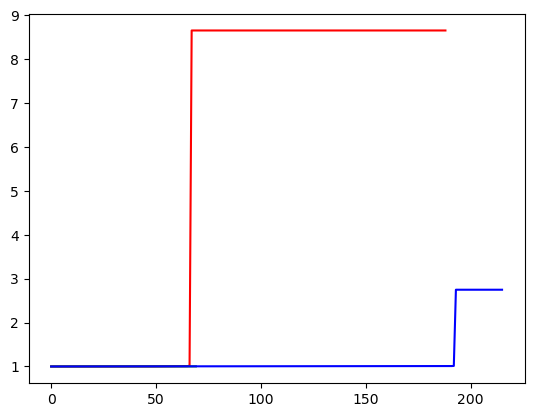

In [304]:
trasctions = 10000
for i in range(trasctions):
    
    if pools[1].buyF(2):
        ts += 0.9985*2
    if pools[0].sell_price(1)>0.66:
        if pools[0].sellF(1):
            ts -= 1
    if pools[2].sell_price(1)>0.66:
        if pools[2].sellF(1):
            ts -= 1
    
    pools[0].fillLiquidity()
    pools[2].fillLiquidity()

    if i % step == 0:
        net_assets[0].append(pools[0].getNet())
        # net_assets[1].append(0)
        net_assets[2].append(pools[2].getNet())
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
for i in range(len(net_assets)):
    plt.plot(net_assets[i], color=colors[i])

In [307]:
print('nets:',[item[-1]for item in net_assets])
print('r_F',[item.rF for item in pools])
print('s_F',[item.sF for item in pools])
print('r_D',[item.rD for item in pools])
print('s_D',[item.sD for item in pools])

total_asset = sum([item.sD for item in pools])-pools[1].sD
total_mint = sum([item.sF for item in pools])
print(total_asset)
print(total_asset/ts)
print(total_mint, ts)


nets: [8.653240597394081, 1.0020007984117303, 2.7482748428758774]
r_F [0.13299999860100797, 1, 0.5880000235774787]
s_F [0.13299999860100797, 38175.209000023875, 0.5880000235774787]
r_D [1.1508809873475982, 1.0029764403460437, 1.6159856724084076]
s_D [1.1508809873475982, 38288.83523231019, 1.6159856724084076]
2.766866659760126
7.247673232201107e-05
38175.93000004605 38175.93000008684


In [157]:
import numpy as np
net_assets = np.array([[1,2],[2,2],[3,2]])
net_assets[:,-1]

array([2, 2, 2])

In [290]:
pools[0].sellF(1)

True

In [ ]:
class singlePool:
    def __init__(self, rD, rF):
        self.rD = rD
        self.rF = rF
        self.sD = rD
        self.limitrF = rF

class AMM:
    def __init__(self):
        self.pools = []
        self.asset_in_F = 0
        self.sF = 0
    
    def addPool(self, rD, rF):
        self.pools.append(singlePool(rD, rF))
        self.asset_in_F += rF
        return len(self.pools)-1
        
    def getNet(self):
        return self.asset_in_F/self.sF
    
    def fillLiquidity(self):
        net = self.getNet()
        rD = self.limitrF*net
        if rD < self.sD:
            self.rF = self.limitrF
            self.rD = rD
            # print('fill liquidity success')
        else:
            self.rF = self.sD/net
            self.rD = self.sD
            # print('fill liquidity failed')
        
    def buyF(self, n):
        # assert n > 0
        # assert self.rF > n
        if self.rF > n > 0:
            # exchange
            K = self.rD*self.rF
            self.rF -= n
            rD = K/self.rF
            incomeD = rD - self.rD
            # supply change
            self.sD += incomeD
            self.sF += (n*0.9985) # 0.15% fee
            # net asset change
            
            # [1]repair by reduce rD
            # net = self.sD/self.sF
            # self.rD = self.rF * net
            # [2]do not repair
            self.rD = rD
            return True
        else:
            return False
    
    def sellF(self, n):
        # assert n > 0
        # assert self.sF > n # 可能市面上都没有足够的F了 
        # 如果该池铸出的流动性全部收回了，此处应当如何处理？
        if self.sF > n >0:
            # exchange
            K = self.rD*self.rF
            rF = self.rF + n
            rD = K/rF
            outD = self.rD - rD
            # supply change
            self.sD -= (outD*0.9985) # 0.15% fee
            self.sF -= n
            # net asset change TODO--
            net = self.sD/self.sF
            # [1] repair by raise rD first？
            # if rF * net < self.sD:
            #     self.rF = rF
            #     self.rD = rF * net
            # else:
            #     # repair by reduce rF
            #     self.rD = rD
            #     self.rF = rD / net
            # [2] only repair by reduce rF
            self.rD = rD
            self.rF = rD / net
            return True
        else:
            return False
    
    def sell_price(self, n):
        if self.sF > n > 0:
            K = self.rD*self.rF
            rF = self.rF + n
            rD = K/rF
            outD = self.rD - rD
            return outD*0.9985
        else:
            return 0

0.8264462809917356
1.0101010101010102
